# __Project 1 - Exercise 3__

In [1]:
using LinearAlgebra, Plots, Statistics, VMLS

#### Functions

In [2]:
"""
    svdr(X; tol = 1e-12)

A compact singular value decomposition ignoring singular values that are numerically inferior

### Arguments
- `X`   : data matrix of predictors.
- `tol` : a tolerance parameter used to settle the numerical rank of X.

### Returns
- `Uᵣ, σᵣ, Vᵣ, r` : the left singular vectors, the singular values, the right singular vectors and the rank of X.

### Reference: 
[Singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)

"""
function svdr(X; tol = 1e-12);
# Compact SVD of input matrix X (https://en.wikipedia.org/wiki/Singular_value_decomposition#Compact_SVD)
# Outputs: The rk non-zero singular values (σ) and corressponding singular vectors (U, V)
# where rk is the rank of A.
    m,n = size(X); r = min(m,n);
    U, σ, V = svd(X);
    mtol = max(max(σ[1]*tol,tol),r*eps());
    ids = findall(σ .> mtol);
    Uᵣ = U[:,ids]; σᵣ = σ[ids]; Vᵣ = V[:,ids];
    r = ids[end];
    return Uᵣ, σᵣ, Vᵣ, r;
end

svdr

In [3]:
using LinearAlgebra, Statistics
"""
    PCRk(X, y)

Principal Component Regression

# Arguments
- `X`: data-matrix
- `y`: response vector
- `k=1`: number of principal components

# Returns
- `β₀`: the constant terms (1×k vector) of the PCR-models for up to k components.
- `Β`: the PC regression coeffs (m×k matrix) for the X-data for up to k components.
"""
function PCRk(X, y; k = 1)
m,n = size(X)
mc  = min(k, min(n,m)-1) # Make sure that the maximum number of components is not too large.
x̄   = mean(X, dims=1) # - row vector of the X-column mean values.
ȳ   = mean(y, dims=1) # - the mean of the response values y.
y₀  = y.- ȳ;          # - the centered response vector.
U, σ, V = svd(X.-x̄)   # - SVD of the centered X-data to find the principal components
U = U[:,1:k]; σ = σ[1:k]; V = V[:,1:k]; # Restriction to the first mc components.
q = (σ.^(-1).*(U'*y₀));   # the regression coeffs for the PCA-scores.
Β = cumsum(V.*q', dims=2) # the PCR-regression coeffs for the X-data based on up to mc components.
β₀ = ȳ .- x̄*Β;            # the correspondning constant terms for the PCR-models.
return β₀, Β;
end

PCRk

In [4]:
function plsHy(X, y; mc = 2)
    # ------------------- Initialize variables ----------------------
    m, n = size(X)
    mc = min(mc, min(n, m) - 1)
    T = zeros(m, mc);    W = zeros(n, mc);    Β = zeros(n, mc)
    P = zeros(n, mc);    q = zeros(1, mc);
    β₀ = zeros(mc);
    B = zeros(mc, 2); # B stored by diagonals (from paper)

    # ------------------- Mean center data ----------------------
    x̄   = mean(X, dims=1)     # - row vector of the X-column mean values.
    ȳ   = mean(y, dims=1)  # - the mean of the response values y.
    y   = y.- ȳ;              # - the centered response vector.
    X   = X.- x̄;              # - the centered X-data

    # ------------------- Calculate first component ----------------------
    w0 = X'y;    w = w0 / norm(w0);
    t = X * w;    ρ = norm(t);    t = t / ρ;    q[1] = (y't)[1]
    W[:, 1] = w;    T[:, 1] = t;    B[1, 1] = ρ;
    d = w / ρ;    Β[:, 1] = (t'y).*d;
    y = y - t * q[1]; # Deflate y
    P[:, 1] = X't;


    # ------------------- Calculate the rest of the components ----------------------
    for a = 2:mc
        w1 = X'y;   w = (w0 - w1)/q[a - 1] - ρ * w;   w0 = w1;
        w = w - W * (W'w);   θ = norm(w);   w = w / θ;
        t = X * w; t = t - T * (T't);
        ρ = norm(t);   t = t / ρ;   q[a] = (y't)[1];
        W[:, a] = w;   T[:, a]= t;
        B[a - 1, 2] = θ;   B[a, 1] = ρ;
        P[:, a] = X't;
    # ------------------- Update regression coefficients -------------------
        d = (w - θ * d) / ρ;
        Β[:, a] = Β[:, a - 1] + q[a].*d;
        y = y - t * q[a];
    end
    β₀ = ȳ .- x̄*Β;
    return β₀, Β, T, W, P, q;
end


plsHy (generic function with 1 method)

In [5]:
"""
    RRLooCV_qr(X,y,λ; ρ = 1:length(y))

Ridge regression modelling alternative with faster LooCV-calculations

### Arguments
- `X` : data matrix of predictors.
- `y` : vector of responses.
- `λ` : the regularizarion parameter value.
- `q` : indices of the samples to be held out one-by-one in the Cross-validation

### Returns
- `β₀, β, resₓᵥ, ŷₓᵥ` : the constant term, the regression coeffs, the LooCV residuals and the LooCV predictions.

### Reference: 
.............

"""
function RRLooCV_qr(X,y,λ; ρ = 1:length(y))
# β0, β, yhat, res, yhatcv, rescv, Q, R, h = rrLooCV_QRfast(X,y,λ,ρ = cvrows);
# Inputs: data X, responses y, reg. param. λ and ρ = cvrows (specification of LooCV-samples).
# Outputs: β0, β, ŷₓᵥ
mρ  = length(ρ); m,n = size(X);
x̄   = mean(X, dims=1); ȳ = mean(y, dims=1); # - mean of data
y  = y.- ȳ ; X  = X.-x̄;              # - centering data.
Q,R = qr([X; sqrt(λ)*I]);  Q = Matrix(Q)[ρ,:];
β   = R\Q'y; β₀ = ȳ - x̄*β;           # The RR regression coeffs.  
res = y[ρ] - X[ρ,:]*β;               # Residuals for the samples specified by ρ.
h   = sum(Q[ρ,:].^2, dims=2) .+ 1/mρ; # The leverage values for the ρ-specified samples.
resₓᵥ= res./(1 .- h);                # LooCV-residuals for the specified samples.
ŷₓᵥ = (y.+ ȳ) - resₓᵥ;               # LooCV-predictions for the specified samples.
return β₀[1], β, resₓᵥ, ŷₓᵥ;
end

RRLooCV_qr

### __3.1)__
We make a model for each of the three responses which results in three sets of regression coefficients. We apply these coefficients on the test set to predict the three responses. We then calculate the RMSE for each response.

In [6]:
using MAT

vars = matread("Sugar.mat");
X_train = vars["Xtrain"]; y_train = vars["Ytrain"];
X_test = vars["Xtest"]; y_test = vars["Ytest"];

#### __PCR__

In [7]:
pc = 10;
y_m, y_n = size(y_train);
ŷ_PCR = zeros(y_m, y_n, pc);

samples = 1:y_m;

for i=1:y_n
    for j in samples
        β₀_PCR, β_PCR = PCRk(X_train[samples .!= j, :], y_train[samples .!= j, i]; k = pc)
        ŷ_PCR[j, i, :] = β₀_PCR .+ X_train[j, :]' * β_PCR
    end
end

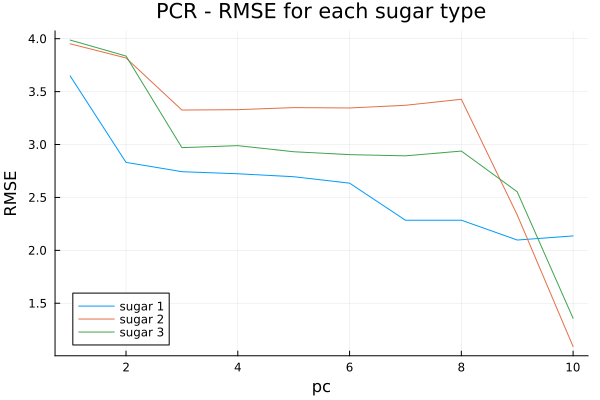

In [8]:
RMSE_PCR = zeros(pc, y_n);
for i=1:pc
    RMSE_PCR[i, :] = sqrt.(sum((y_train .- ŷ_PCR[:, :, i]).^2, dims=1) ./ y_m)
end

PCR_plot = plot(xlabel = "pc", ylabel = "RMSE", title="PCR - RMSE for each sugar type")
for i=1:y_n
    plot!(PCR_plot, RMSE_PCR[:, i], label = "sugar $i")
end
display(PCR_plot)



In [9]:
min_rmse = argmin(sum(RMSE_PCR, dims=2)')[1]
m, n = size(X_train)
β_PCR = zeros(n + 1, y_n)
for i=1:y_n
    β₀_PCRi, β_PCRi = PCRk(X_train, y_train[:, i]; k = 10)
    β_PCR[:, i] = [β₀_PCRi[min_rmse]; β_PCRi[:, min_rmse]]
end

#### __PLS__

In [10]:
pc = 10;
y_m, y_n = size(y_train);
ŷ_PLS = zeros(y_m, y_n, pc);
samples = 1:y_m;

for i=1:y_n
    for j in samples
        β₀_PLSj, β_PLSj, ~, ~, ~, ~ = plsHy(X_train[samples .!= j, :], y_train[samples .!= j, i]; mc = pc)
        ŷ_PLS[j, i, :] = β₀_PLSj .+ X_train[j, :]' * β_PLSj
    end
end

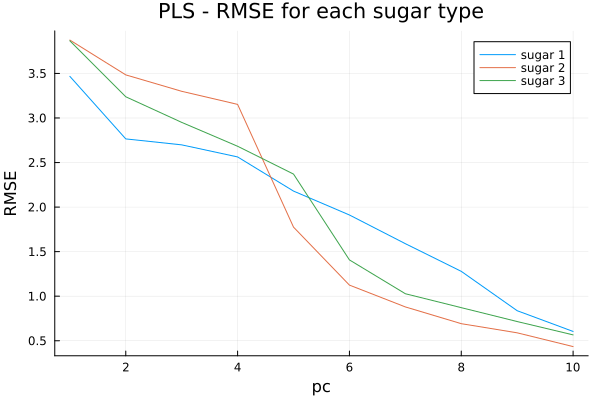

In [11]:
RMSE_PLS = zeros(pc, y_n);
for i = 1:pc
    RMSE_PLS[i, :] = sqrt.(sum((y_train .- ŷ_PLS[:, :, i]).^2, dims=1) ./ y_m)
end

PLS_plot = plot(xlabel = "pc", ylabel = "RMSE", title="PLS - RMSE for each sugar type")
for i=1:y_n
    plot!(PLS_plot, RMSE_PLS[:, i], label = "sugar $i")
end
display(PLS_plot)

In [12]:
min_rmse = argmin(sum(RMSE_PLS, dims=2)')[1]
m, n = size(X_train)
β_PLS = zeros(n + 1, y_n)
for i=1:y_n
    β₀_PLSi, β_PLSi, ~, ~, ~, ~ = plsHy(X_train, y_train[:, i]; mc = 10)
    β_PLS[:, i] = [β₀_PLSi[min_rmse]; β_PLSi[:, min_rmse]]
end

#### __Ridge regression__

In [13]:
λₛ = 10 .^(range(-5,stop=2,length=10))';
y_m, y_n = size(y_train);
m, n = size(X_train);
ŷ_RR = zeros(y_m, y_n, length(λₛ));

for i=1:y_n
    for (j, λ) in enumerate(λₛ)
        ~, ~, ~, ŷ_RR[:, i, j] = RRLooCV_qr(X_train, y_train[:, i], λ)
    end
end

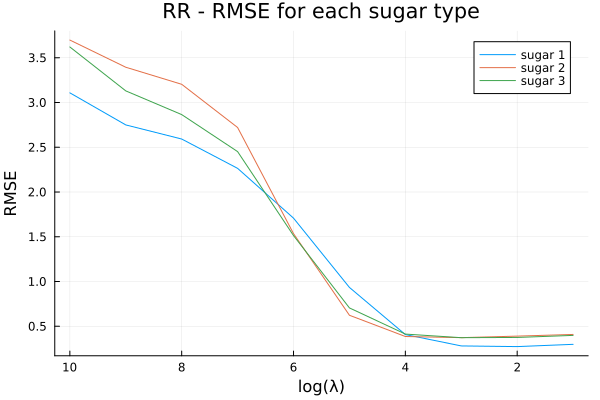

In [14]:
RMSE_RR = zeros(length(λₛ), y_n);
for i = 1:pc
    RMSE_RR[i, :] = sqrt.(sum((y_train .- ŷ_RR[:, :, i]).^2, dims=1) ./ y_m)
end

RR_plot = plot(xlabel = "log(λ)", ylabel = "RMSE", title="RR - RMSE for each sugar type", xflip=true, legend=:topright)
for i=1:y_n
    plot!(RR_plot, RMSE_RR[:, i], label = "sugar $i")
end
display(RR_plot)


In [15]:
min_rmse = argmin(sum(RMSE_RR, dims=2)')[1]
m, n = size(X_train)
β_RR = zeros(n + 1, y_n)
for i=1:y_n
    β₀_RRi, β_RRi = PCRk(X_train, y_train[:, i]; k = 10)
    β_RR[:, i] = [β₀_RRi[min_rmse]; β_RRi[:, min_rmse]]
end

### __3.2)__

In [16]:
RMSEtest = zeros(y_n, 3)
for (i, β) in enumerate([β_PCR, β_PLS, β_RR])
    ŷ = X_test * β[2:end, :] .+ β[1, :]'
    res = y_test .- ŷ
    RMSEtest[:, i] = sqrt.(sum(res.^2, dims=1) ./ size(y_test)[1])
end

using DataFrames
RMSEtest_df = DataFrame()
RMSEtest_df[!, :model] = ["PCR", "PLS", "RR"]
RMSEtest_df[!, :y1] = RMSEtest[:, 1]
RMSEtest_df[!, :y2] = RMSEtest[:, 2]
RMSEtest_df[!, :y3] = RMSEtest[:, 3]
RMSEtest_df

Row,model,y1,y2,y3
,String,Float64,Float64,Float64
1,PCR,10.1786,9.87223,10.1786
2,PLS,9.8844,9.72894,9.8844
3,RR,11.1682,10.8757,11.1682


### __3.3)__

In the PCR and PLS we manually calculated the LooCV-predictions having to refit the model for each sample for 3 response vectors. This wasn't necessary in the Ridge regression model as we from one model fitting could calculate the LooCV-predictions for each of three responses. So by utilizing this possibility we can further do calculations more efficiently.

In [17]:
"""
    TregsRLooCV(X, y, λₛ; smo = 0)

Ridge-/Tikhonov regression modelling alternative with faster LooCV-calculations for many

### Arguments
- `X` : data matrix of predictors.
- `y` : vector of responses.
- `λₛ` : a vector of regularizarion parameter values.
- `smo` : order of smoothing in regularization matrix L.

### Returns
- `PRESSλₛ, minid, λₘᵢₙ, βₘᵢₙ, hₘᵢₙ, U, σ, V` : see explanations in the comments below.

### Reference: 
.............

"""
function TregsRLooCV(X, y, λₛ; smo = 0) # THE INPUTs ARE: (X,y)-data, λs: a vector of reg. param. values, smo: order of smoothing.
m, n   = size(X); λₛ = reshape(λₛ, 1, length(λₛ))  # λₛ is a row vector of many reg. parameter values.
x̄     = mean(X, dims=1); ȳ = mean(y, dims=1);  y  = y.- ȳ;  X  = X.-x̄;  # mean and centering of (X,y)-data.
if smo > 0 # smo. the order of smoothing.
    L  = [speye(n); zeros(smo,n)]; for i = 1:smo L = diff(L, dims = 1); end
    X  = X/L; # L is a discrete derivative 'smoothing matrix' of order "smo".
end
U, σ, V = svdr(X); σ_plus_λₛ_over_σ = (σ.+(λₛ./σ)); # SVD of X & (σ, λ)-factors required for calc. of β-coeffs and H.
β       = V*((U'*y)./σ_plus_λₛ_over_σ);             # Simultaneous calc. of the β-coeffs for all λₛ.
H       = (U.^2)*(σ./σ_plus_λₛ_over_σ).+1/m;        # Simultaneous calc. of the leverage vectors for all λₛ.
# PRESSλₛ   = sum(((y.-X*β)./(1 .-H)).^2, dims=1)'; # The PRESS-values corresponding to all λₛ.
PRESSλₛ  = sum(((y.-U*((σ.*(U'*y))./σ_plus_λₛ_over_σ))./(1 .-H)).^2, dims=1)'; # The PRESS-values corresponding to all λₛ.
minid   = argmin(PRESSλₛ)[1];   # Find index of minimum press-value & identify corresponding λ-value, ...
if smo  > 0  β = L\β; end         # The X-regression coeffs in cases of smoothing (smo > 0).
β  = [ȳ .- x̄*β; β]; βₘᵢₙ = β[:,minid]; λₘᵢₙ = λₛ[minid]; hₘᵢₙ = H[:,minid]; # ...regression coeffs including the constant term (βₘᵢₙ) and leverages (hₘᵢₙ).
return PRESSλₛ, minid, λₘᵢₙ, βₘᵢₙ, hₘᵢₙ, U, σ, V;     # The OUTPUT-parameters of the function.
end

TregsRLooCV

In [18]:
λₛ = 10 .^(range(-5,stop=2,length=10))';
β_TR = zeros(n + 1, y_n)

for i=1:y_n
    ~, ~, ~, βₘᵢₙ, ~, ~, ~, ~ = TregsRLooCV(X_train, y_train[:, i], λₛ)
    β_TR[:, i] = βₘᵢₙ
end

In [19]:
ŷ_test_TR = X_test * β_TR[2:end, :] .+ β_TR[1, :]'
RMSE_test_TR = sqrt.(sum((y_test .- ŷ_test_TR).^2, dims=1) ./ size(y_test)[1])

push!(RMSEtest_df, (model = "TR", y1 = RMSE_test_TR[1], y2 = RMSE_test_TR[2], y3 = RMSE_test_TR[3]))
RMSEtest_df

Row,model,y1,y2,y3
,String,Float64,Float64,Float64
1,PCR,10.1786,9.87223,10.1786
2,PLS,9.8844,9.72894,9.8844
3,RR,11.1682,10.8757,11.1682
4,TR,1.74045,1.00158,1.69441


#### __Multi-response TregsRLooCV__

The SVD only need to be calculated once as it is dependent only on $X$ and is not dependent on the responses given by $Y$.

In [20]:
function MRTregsRLooCV(X, y, λₛ; smo = 0)
    m, n = size(X); λₛ = reshape(λₛ, 1, length(λₛ)) # λₛ is a row vector of many reg. parameter values.
    ~, q = size(y);
    x̄ = mean(X, dims=1); ȳ = mean(y, dims=1);  
    y  = y.- ȳ;  X = X.-x̄;  # mean and centering of (X,y)-data.
    
    if smo > 0 # smo. the order of smoothing.
        L = [speye(n); zeros(smo,n)]; for i = 1:smo L = diff(L, dims = 1); end
        X = X/L; # L is a discrete derivative 'smoothing matrix' of order "smo".
    end
    
    U, σ, V, _ = svdr(X); # SVD
    σ_plus_λₛ_over_σ = (σ.+(λₛ./σ)); #(σ, λ)-factors required for calc. of β-coeffs and H.
    Hᵢ = (U.^2)*(σ./σ_plus_λₛ_over_σ).+1/m; # Simultaneous calc. of the leverage vectors for all λₛ

    PRESSλₛ = zeros(length(λₛ), q) 
    minids = zeros(Int, q)
    λₘᵢₙ = zeros(q)
    βₘᵢₙ = zeros(n + 1, q)
    hₘᵢₙ = zeros(m, q)
    
    
    for i=1:q # Iterate over the responses
        y_i = y[:, i]
        βᵢ = V*((U'*y_i)./σ_plus_λₛ_over_σ); # Simultaneous calc. of the β-coeffs for all λₛ.
        PRESSλₛ[:, i] = sum(((y_i.-U*((σ.*(U'*y_i))./σ_plus_λₛ_over_σ))./(1 .-Hᵢ)).^2, dims=1)'; # The PRESS-values corresponding to all λₛ.
        minid = argmin(PRESSλₛ[:, i])[1];      # Find index of minimum press-value & identify corresponding λ-value, ...
        if smo  > 0  βᵢ = L\βᵢ; end # The X-regression coeffs in cases of smoothing (smo > 0). 
        βᵢ  = [ȳ[i] .- x̄*βᵢ; βᵢ]; minids[i] = minid;
        βₘᵢₙ[:, i] = βᵢ[:, minid]; λₘᵢₙ[i] = λₛ[minid]; hₘᵢₙ[:, i] = Hᵢ[:, minid]; # ...regression coeffs including the constant term (βₘᵢₙ) and leverages (hₘᵢₙ).
    end

    return PRESSλₛ, minids, λₘᵢₙ, βₘᵢₙ, hₘᵢₙ, U, σ, V;     # The OUTPUT-parameters of the function.
end
    

MRTregsRLooCV (generic function with 1 method)

In [21]:
λₛ = 10 .^(range(-5,stop=2,length=10))';
~, ~, λ_MTR, β_MTR, ~, ~, ~, ~ = MRTregsRLooCV(X_train, y_train, λₛ, smo = 1);

In [22]:
ŷ_test_MTR = X_test * β_MTR[2:end, :] .+ β_MTR[1, :]'
RMSE_test_MTR = sqrt.(sum((y_test .- ŷ_test_MTR).^2, dims=1) ./ size(y_test)[1])

push!(RMSEtest_df, (model = "MTR+smoothing", y1 = RMSE_test_MTR[1], y2 = RMSE_test_MTR[2], y3 = RMSE_test_MTR[3]))
RMSEtest_df

Row,model,y1,y2,y3
,String,Float64,Float64,Float64
1,PCR,10.1786,9.87223,10.1786
2,PLS,9.8844,9.72894,9.8844
3,RR,11.1682,10.8757,11.1682
4,TR,1.74045,1.00158,1.69441
5,MTR+smoothing,0.93114,0.490339,0.818516
